# Analysis of the datasets

In [ ]:
NOTEBOOK_CONFIG = {'label_mode': True,
                   'train_mode': True,
                   'IMG_LENGTH': 0.377,
                   'IMG_WIDTH': 0.143,
                   'IMG_XDIM': 143,
                   'IMG_YDIM': 377,
                   'task' : 'detect',
                   'labels_type' : 'Labelsv0_detect'
                   }

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os

import pandas as pd
import numpy as np

import seaborn as sns
import scipy.io

from matplotlib import pyplot as plt
from adjustText import adjust_text

from PIL import Image

# Load modules

In [11]:
from helpers.gaussian_generator import (generate_grid, 
                                        TfromXX, 
                                        generate_distribution)
from helpers.auxiliary_functions import parameters_extract
from helpers.aux_plotter import (plot_boxes_gmm,
                                 gaussians_labelled,
                                 plot_grayscale)

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [13]:
# Load 400 gaussians
mat = scipy.io.loadmat('docs/Data/db_80beam.mat')
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [81]:
# Generate GRID
x, y = generate_grid((0, NOTEBOOK_CONFIG['IMG_WIDTH']), 
                     (0, NOTEBOOK_CONFIG['IMG_LENGTH']), 
                     NOTEBOOK_CONFIG['IMG_XDIM'], 
                     NOTEBOOK_CONFIG['IMG_YDIM'])

## Data analysis

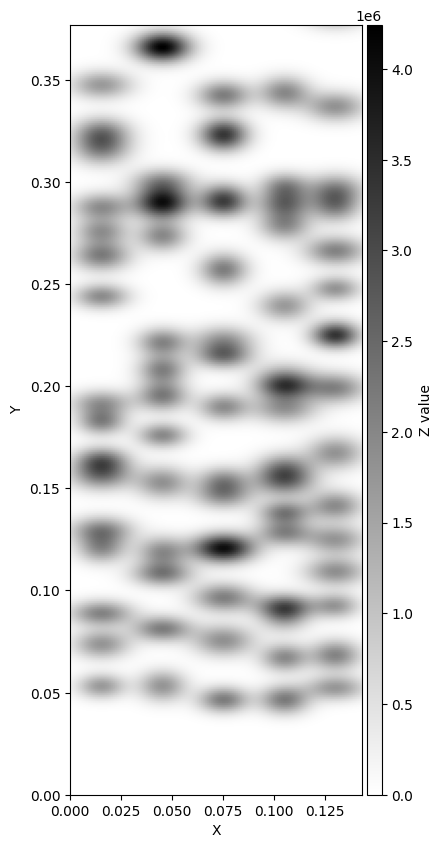

In [26]:
# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots(figsize = (15, 10))
n_image = 109
plot_grayscale(x, y, mat['F_data'][:,:, n_image], ax)
image = [x, y, mat['F_data'][:,:, n_image]]

### Generation using same code from Matlab

In [ ]:
# Generation
x_tt, y_tt, z_tt = TfromXX(143, 377, np.array(mat['Fit_flux'])[:, 4])

In [ ]:
# Error reconstruction
np.linalg.norm(image[2] - z_tt)

85528.07456334277

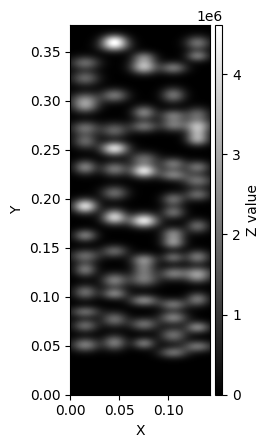

In [ ]:
fig, ax = plt.subplots()
plot_grayscale(x_tt, y_tt, z_tt, ax = ax)

### Using another way of generation

In [27]:
# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], 4)

In [28]:
# Organize the tuples
params = list(zip(xs,
                  ys,
                  dispersion_x / np.sqrt(2), # Convert to sigma
                  dispersion_y / np.sqrt(2),
                  amplitude,
                  len(amplitude) * [0])) #

In [29]:
# Generate gaussians
x, y, z = generate_distribution((0, NOTEBOOK_CONFIG['IMG_WIDTH']),
                                (0, NOTEBOOK_CONFIG['IMG_LENGTH']),
                                NOTEBOOK_CONFIG['IMG_XDIM'],
                                NOTEBOOK_CONFIG['IMG_YDIM'],
                                params,
                                rotation = True)

In [ ]:
# Difference from methods
np.linalg.norm(z - z_tt)

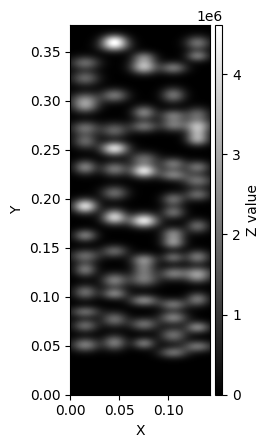

In [ ]:
fig, ax = plt.subplots()
plot_grayscale(x, y, z, ax = ax)

### Ideal gaussians - Beta values

In [57]:
# Beta values
beta_amplitude = mat['beta'][::5]
beta_xs  = mat['beta'][1::5]
beta_ys = mat['beta'][2::5]
beta_dispersion_x = mat['beta'][3::5]
beta_dispersion_y = mat['beta'][4::5]

In [58]:
np.mean(beta_xs)

0.07401653300000002

In [59]:
np.mean(beta_dispersion_y)

0.0051873

In [60]:
# Organize the tuples
params = list(zip(beta_xs,
                  beta_ys,
                  beta_dispersion_x/np.sqrt(2),
                  beta_dispersion_y/np.sqrt(2),
                  beta_amplitude,
                  len(beta_amplitude) * [0]))

In [97]:
# Generate gaussians
x, y, z = generate_distribution((0, 0.143), (0, 0.377), 143, 377, params)

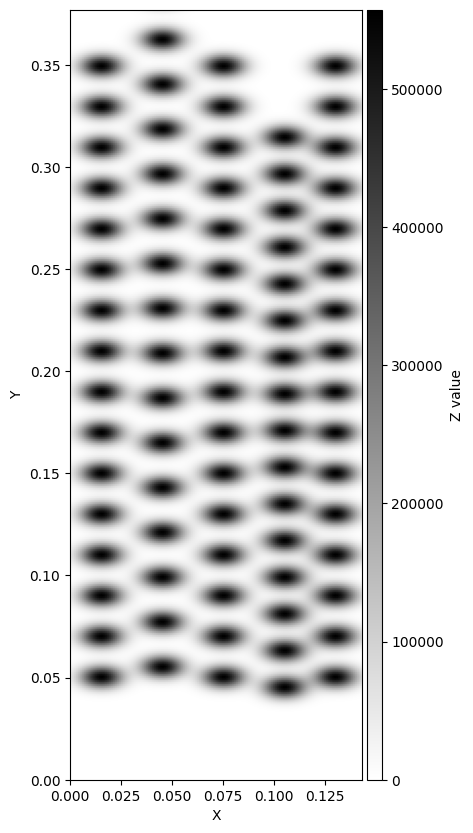

In [62]:
fig, ax = plt.subplots(figsize = (15, 10))
plot_grayscale(x, y, z, ax = ax)

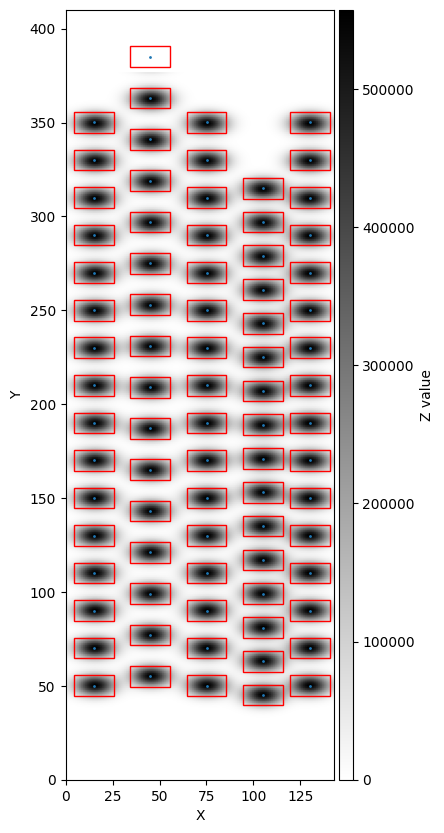

In [98]:
# Create figure and axes
fig, ax = plt.subplots(1, figsize = (15, 10))

# Labelling
x = 1000 * x
y = 1000 * y
plot_grayscale(x, y, z, ax = ax)
plot_boxes_gmm(means = list(zip(beta_xs.flatten(), beta_ys.flatten())),
               covariances = [np.diag(cov) for cov in zip((beta_dispersion_x.flatten()/np.sqrt(2))**2,
                                                          (beta_dispersion_y.flatten()/np.sqrt(2))**2)],
               ax = ax,
               beta = 3)
ax.scatter(beta_xs * 1000, beta_ys * 1000, s = 1)

### Types of images based on the divergence from Beta image

In [ ]:
def metrics_differences(diff_array):
  """
  Computes some metrics about the images
  Main objective is understanding the differenttiation of the images in relation
  to the started one (betas)
  """
  mean_diff = np.mean(diff_array)
  abs_mean_diff = np.mean(np.abs(diff_array))
  std_diff = np.std(diff_array)
  min_diff = np.min(diff_array)
  max_diff = np.max(diff_array)
  return {'mean' : mean_diff,
          'abs_mean' : abs_mean_diff,
          'std' : std_diff,
          'min' : min_diff,
          'max' : max_diff}

In [ ]:
def compute_diff_image(beta_amplitude,
                       beta_xs,
                       beta_ys,
                       beta_dispersion_x,
                       beta_dispersion_y,
                       n_image,
                       mat_data,
                       return_percentage = False):
  # Select image parameters
  (amplitude,
   xs,
   ys,
   dispersion_x,
   dispersion_y) = parameters_extract(mat_data['Fit_flux'],
                                      n_image)

  # Dict betas
  dict_beta = {'amplitude' : beta_amplitude.flatten(),
               'x center' : beta_xs.flatten(),
               'y center' : beta_ys.flatten(),
               'x dispersion' : beta_dispersion_x.flatten(),
               'y dispersion' : beta_dispersion_y.flatten()
              }

  # Differences
  dict_diff_image = {'amplitude' : beta_amplitude.flatten() - amplitude,
                    'x center' : beta_xs.flatten() - xs,
                    'y center' : beta_ys.flatten() - ys,
                    'x dispersion' : beta_dispersion_x.flatten() - dispersion_x,
                    'y dispersion' : beta_dispersion_y.flatten() - dispersion_y}

  # All metrics for one image
  dict_metrics_all = {}
  for dim_eval in dict_diff_image.keys():
    # Metrics for beta
    metrics_beta = metrics_differences(dict_beta[dim_eval])

    # Metrics for the image
    metrics_image =  metrics_differences(dict_diff_image[dim_eval])

    if return_percentage:
      dict_metrics =  {'n_image' : [n_image],
            f'mean {dim_eval}' : [metrics_image['mean']/metrics_beta['mean']],
            f'mean - abs {dim_eval}' : [metrics_image['abs_mean']/metrics_beta['abs_mean']],
            f'std {dim_eval}': [metrics_image['std']/metrics_beta['std']],
            f'min {dim_eval}' : [metrics_image['min']/metrics_beta['min']],
            f'max {dim_eval}' : [metrics_image['max']/metrics_beta['max']]}
    else:
      # Dictionary
      dict_metrics =  {'n_image' : [n_image],
                      f'mean {dim_eval}' : [metrics_image['mean']],
                      f'mean - abs {dim_eval}' : [metrics_image['abs_mean']],
                      f'std {dim_eval}': [metrics_image['std']],
                      f'min {dim_eval}' : [metrics_image['min']],
                      f'max {dim_eval}' : [metrics_image['max']]}

    # Merge dictionaries - n_image should be equal
    dict_metrics_all = {**dict_metrics_all, **dict_metrics}

  return dict_metrics_all

In [ ]:
# Initialize
image_metrics_all = compute_diff_image(beta_amplitude,
                                       beta_xs,
                                       beta_ys,
                                       beta_dispersion_x,
                                       beta_dispersion_y,
                                       0,
                                       mat)

# Append computed vlaue for image
for i_image in range(1, mat['Fit_flux'].shape[1]):
  eval_image = compute_diff_image(beta_amplitude,
                          beta_xs,
                          beta_ys,
                          beta_dispersion_x,
                          beta_dispersion_y,
                          i_image,
                          mat)

  # Append values in the dictionary
  for key in image_metrics_all.keys():
    if key in eval_image:
      image_metrics_all[key] += eval_image[key]

# Dataframe
df_imgmetrics = pd.DataFrame.from_dict(image_metrics_all)

In [ ]:
# Initialize
image_metrics_all = compute_diff_image(beta_amplitude,
                                       beta_xs,
                                       beta_ys,
                                       beta_dispersion_x,
                                       beta_dispersion_y,
                                       0,
                                       mat,
                                       return_percentage = True)

# Append computed vlaue for image
for i_image in range(1, mat['Fit_flux'].shape[1]):
  eval_image = compute_diff_image(beta_amplitude,
                          beta_xs,
                          beta_ys,
                          beta_dispersion_x,
                          beta_dispersion_y,
                          i_image,
                          mat,
                          return_percentage = True)

  # Append values in the dictionary
  for key in image_metrics_all.keys():
    if key in eval_image:
      image_metrics_all[key] += eval_image[key]

# Dataframe
df_imgmetrics_pct = pd.DataFrame.from_dict(image_metrics_all)

<ipython-input-69-8cdbedb0b058>:46: RuntimeWarning: divide by zero encountered in double_scalars
  f'std {dim_eval}': [metrics_image['std']/metrics_beta['std']],


In [ ]:
df_imgmetrics.head()

,n_image,mean amplitude,mean - abs amplitude,std amplitude,min amplitude,max amplitude,mean x center,mean - abs x center,std x center,min x center,...,mean x dispersion,mean - abs x dispersion,std x dispersion,min x dispersion,max x dispersion,mean y dispersion,mean - abs y dispersion,std y dispersion,min y dispersion,max y dispersion
0,0,-1.404661e+06,1.404661e+06,154524.989228,-1.668455e+06,-1.122374e+06,0.0,0.0,0.0,0.0,...,-0.003185,0.003185,0.001041,-0.004966,-0.001058,-0.001493,0.001493,0.000555,-0.002545,-0.000538
1,1,-1.420337e+06,1.420337e+06,154850.927731,-1.669720e+06,-1.126805e+06,0.0,0.0,0.0,0.0,...,-0.002902,0.002902,0.001191,-0.004928,-0.000999,-0.001579,0.001579,0.000617,-0.002586,-0.000561
2,2,-1.381123e+06,1.381123e+06,164809.587004,-1.662665e+06,-1.124813e+06,0.0,0.0,0.0,0.0,...,-0.003167,0.003167,0.001173,-0.004957,-0.001040,-0.001631,0.001631,0.000597,-0.002592,-0.000541
3,3,-1.389979e+06,1.389979e+06,157500.382805,-1.661210e+06,-1.117415e+06,0.0,0.0,0.0,0.0,...,-0.002743,0.002743,0.001116,-0.004943,-0.000998,-0.001504,0.001504,0.000590,-0.002587,-0.000551
4,4,-1.354681e+06,1.354681e+06,150961.799842,-1.669893e+06,-1.124724e+06,0.0,0.0,0.0,0.0,...,-0.002925,0.002925,0.001170,-0.004939,-0.001091,-0.001510,0.001510,0.000599,-0.002545,-0.000573


In [ ]:
df_imgmetrics_pct.head()

,n_image,mean amplitude,mean - abs amplitude,std amplitude,min amplitude,max amplitude,mean x center,mean - abs x center,std x center,min x center,...,mean x dispersion,mean - abs x dispersion,std x dispersion,min x dispersion,max x dispersion,mean y dispersion,mean - abs y dispersion,std y dispersion,min y dispersion,max y dispersion
0,0,-2.522130e+00,2.522130e+00,1.327360e+15,-2.995783e+00,-2.015271e+00,0.0,0.0,0.0,0.0,...,-0.320261,0.320261,inf,-0.499403,-0.106390,-0.287813,0.287813,inf,-0.490539,-0.103624
1,1,-1.420337e+06,1.420337e+06,1.548509e+05,-1.669720e+06,-1.126805e+06,0.0,0.0,0.0,0.0,...,-0.002902,0.002902,0.001191,-0.004928,-0.000999,-0.001579,0.001579,0.000617,-0.002586,-0.000561
2,2,-1.381123e+06,1.381123e+06,1.648096e+05,-1.662665e+06,-1.124813e+06,0.0,0.0,0.0,0.0,...,-0.003167,0.003167,0.001173,-0.004957,-0.001040,-0.001631,0.001631,0.000597,-0.002592,-0.000541
3,3,-1.389979e+06,1.389979e+06,1.575004e+05,-1.661210e+06,-1.117415e+06,0.0,0.0,0.0,0.0,...,-0.002743,0.002743,0.001116,-0.004943,-0.000998,-0.001504,0.001504,0.000590,-0.002587,-0.000551
4,4,-1.354681e+06,1.354681e+06,1.509618e+05,-1.669893e+06,-1.124724e+06,0.0,0.0,0.0,0.0,...,-0.002925,0.002925,0.001170,-0.004939,-0.001091,-0.001510,0.001510,0.000599,-0.002545,-0.000573


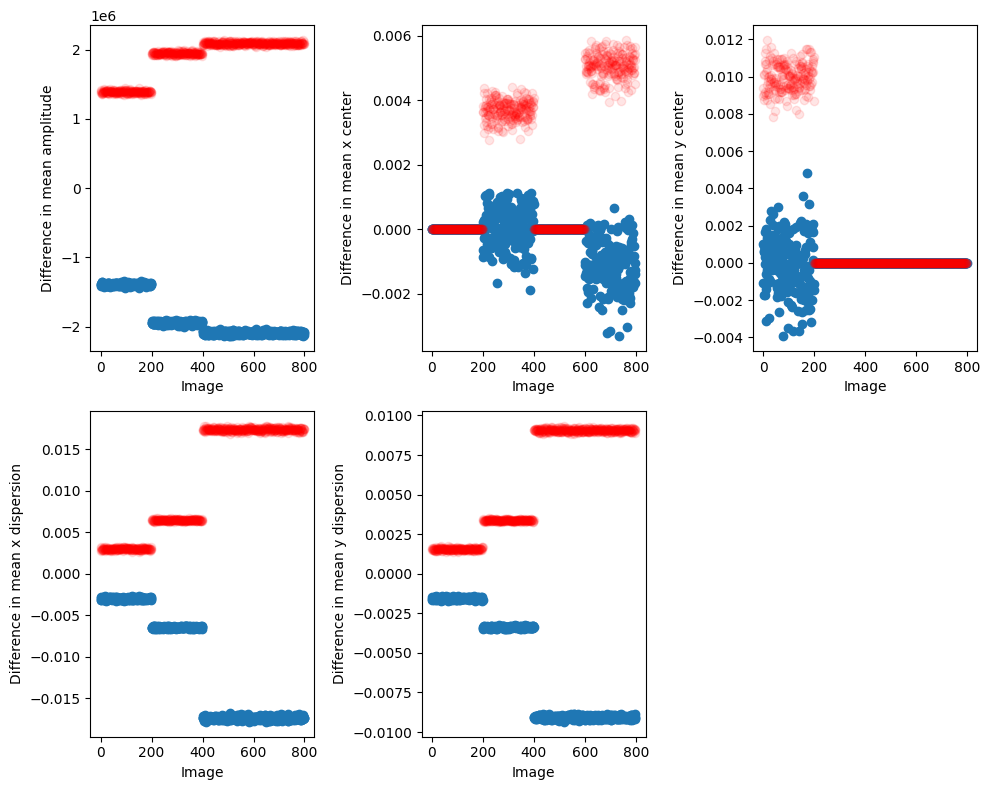

In [ ]:
# Check image distribution
list_plot = [('mean amplitude', 'mean - abs amplitude'),
             ('mean x center', 'mean - abs x center'),
             ('mean y center', 'mean - abs y center'),
             ('mean x dispersion', 'mean - abs x dispersion'),
             ('mean y dispersion', 'mean - abs y dispersion')]


fig, ax = plt.subplots(2, 3, figsize=(10, 8))

flat_ax = ax.flatten()
for a, (y1, y2) in zip(flat_ax, list_plot):
    a.scatter(df_imgmetrics['n_image'],
              df_imgmetrics[y1])
    a.scatter(df_imgmetrics['n_image'],
              df_imgmetrics[y2],
              color='red',
              alpha=0.1)
    a.set_xlabel('Image')
    a.set_ylabel(f'Difference in {y1}')

for i in range(len(list_plot), len(flat_ax)):
    flat_ax[i].axis('off')

plt.tight_layout()
plt.show()

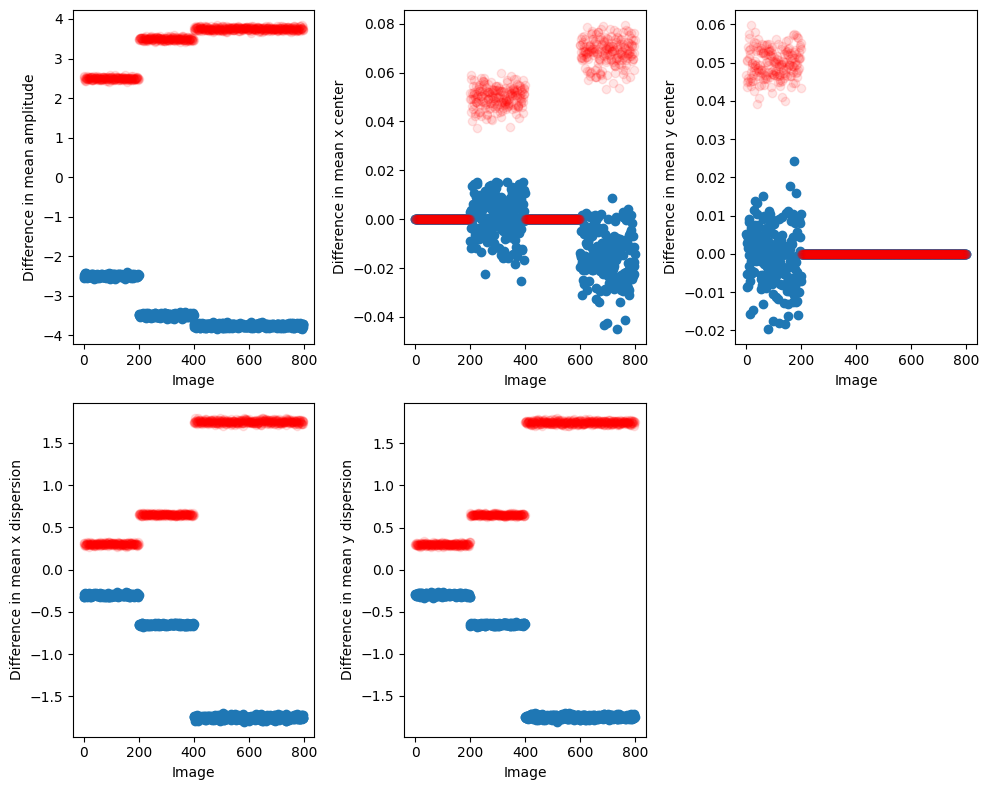

In [ ]:
# Check image distribution
list_plot = [('mean amplitude', 'mean - abs amplitude'),
             ('mean x center', 'mean - abs x center'),
             ('mean y center', 'mean - abs y center'),
             ('mean x dispersion', 'mean - abs x dispersion'),
             ('mean y dispersion', 'mean - abs y dispersion')]


fig, ax = plt.subplots(2, 3, figsize=(10, 8))

flat_ax = ax.flatten()
for a, (y1, y2) in zip(flat_ax, list_plot):
    a.scatter(df_imgmetrics_pct['n_image'],
              df_imgmetrics_pct[y1])
    a.scatter(df_imgmetrics_pct['n_image'],
              df_imgmetrics_pct[y2],
              color='red',
              alpha=0.1)
    a.set_xlabel('Image')
    a.set_ylabel(f'Difference in {y1}')

for i in range(len(list_plot), len(flat_ax)):
    flat_ax[i].axis('off')

plt.tight_layout()
plt.show()

### Qualifying images
Amplitude: Images
- 0 - 200: All amplitudes are higher around 1. (250%)
- 200 - 400: All amplitudes are higher around 2E6 (350%)
- 400 - 800: All amplitudes are higher around 2.1E6 (400%)

x center: Images
- 0 - 200: Coincides with beta xs
- 200 - 400: It has some Gaussians deslocated to left and others to right around 0.004 in x direction
- 400 - 600: Coincides with beta xs
- 600 - 800: It has some Gaussians deslocated to left and others to right around 0.005 in x direction

y center: Images
- 0 - 200:  It has some Gaussians deslocated to up and other to down around 0.01 in y direction
- 200 - 800: Coincides with beta ys

dispersion in x: Images
- 0 - 200: Higher dispersion in x directions around 0.003 (40%)
- 200 - 400: Higher dispersion in x direction around 0.006 (60%)
- 400 - 800: Higher dispersion in x direction around 0.017 (170%)
                        
dispersion in y: Images
- 0 - 200: Higher dispersion in y direction around 0.002 (40%)
- 200 - 400: Higher dispersion in y direction around 0.003 (60%)
- 400 - 800: Higher dispersion in y direction around 0.01 (170%)      

In [ ]:
# Check image distribution
fig, ax = plt.subplots(figsize = (15, 10))
c = ax.scatter(df_imgmetrics['mean x center'],
               df_imgmetrics['mean y center'],
               c = df_imgmetrics['n_image'],
               cmap = 'Reds')
ax.set_ylabel('Difference in y center')
ax.set_xlabel('Difference in x center')
plt.colorbar(c)

## Box of the gaussians - using dispersion_x and dispersion_y (from true parameters)

In [54]:
# Load data
n_image = 609

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

In [55]:
# Structure covariances
covariances = [np.diag(cov) for cov in zip((dispersion_x/np.sqrt(2))**2, 
                                           (dispersion_y/np.sqrt(2))**2)]

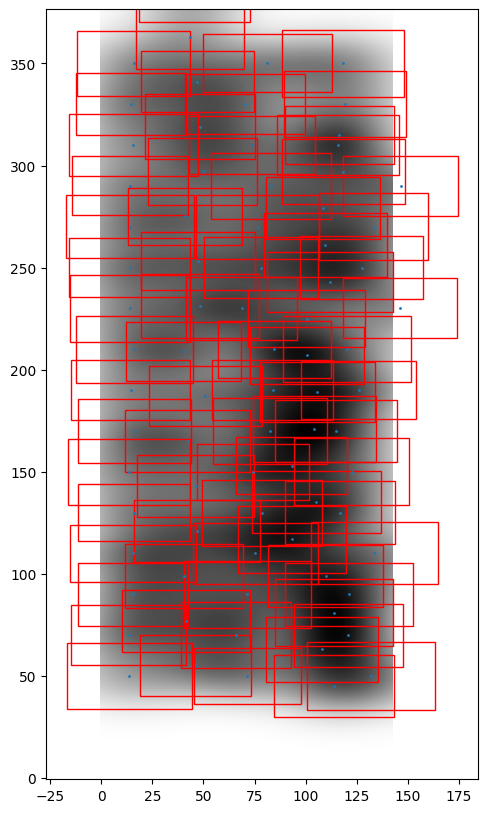

In [56]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, ax = plt.subplots(1, figsize = (15, 10))

# Labelling
ax.imshow(im)
plot_boxes_gmm(means = list(zip(xs, ys)),
               covariances = covariances,
               ax = ax,
               beta = 3)
ax.set_ylim(ax.get_ylim()[::-1])
ax.scatter(xs * 1000, ys * 1000, s = 1)

Number of indentifiable Gaussians (center in the image): 78


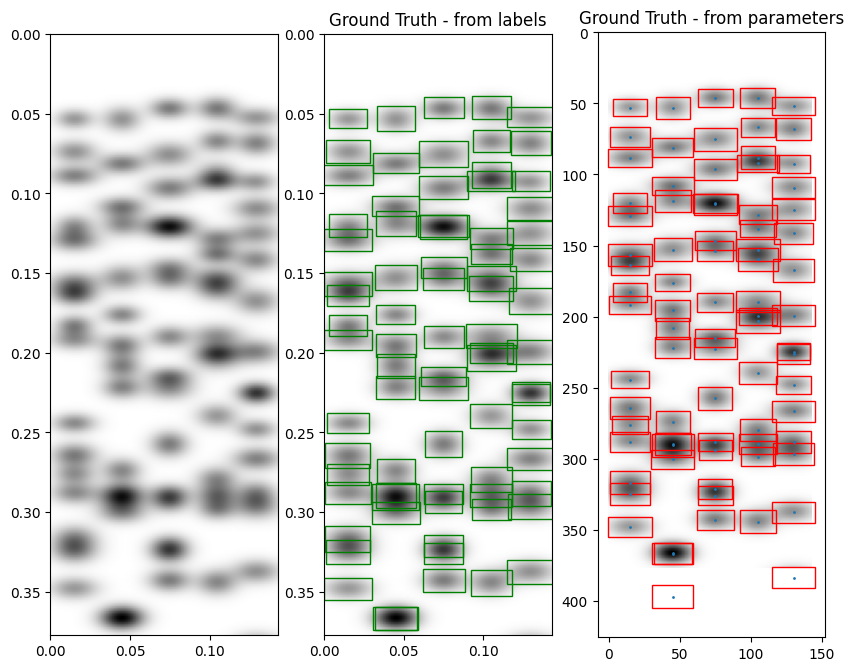

In [40]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize = (10, 10))

# Display the image
axs[2].imshow(im)
plot_boxes_gmm(means = list(zip(xs, ys)),
               covariances = covariances,
               ax = axs[2],
               beta = 3)
axs[2].set_title("Ground Truth - from parameters")
axs[2].scatter(xs * 1000, ys * 1000, s = 1)

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = NOTEBOOK_CONFIG['task'],
                   colorbar = False)
axs[1].set_title("Ground Truth - from labels")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])

axs[0].invert_yaxis()
axs[1].invert_yaxis()

for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

# Results from models


In [ ]:
date_of_results = "2023-08-21"
snapshot_folder_path = f"""docs/Results/snapshot_v{date_of_results}/"""

In [ ]:
# Dataframe results
run_name = "2023-08-21_15-02-46_E1GMM"
df_results =  pd.read_csv(snapshot_folder_path + f'results_{run_name}.csv',
              index_col = 0)
df_results['model'] = run_name.split('_')[-1]
df_results.columns = [col.split(' - ')[0] for col in df_results.columns]

In [ ]:
# Append all results
list_analysis = [(a.split('_')[-3] + '_' + a.split('_')[-2] +
                  '_' +
                  a.split('_')[-1]).rstrip('.csv').rstrip('.txt')
                  for a in os.listdir(snapshot_folder_path)
                  if a.split('_')[-1].split('.')[1] == 'csv']
list_analysis.remove("2023-08-21_15-02-46_E1GMM")
for run_name in list_analysis:
  df_append = pd.read_csv(snapshot_folder_path + f'results_{run_name}.csv',
                          index_col = 0)
  df_append['model'] = run_name.split('_')[-1]
  df_append.columns = [col.split(' - ')[0] for col in df_append.columns]
  df_results = pd.concat([df_results, df_append], axis = 0)

In [ ]:
date_of_results = "2023-08-22"
snapshot_folder_path = f"""docs/Results/snapshot_v{date_of_results}/"""

In [ ]:
# Append all results
list_analysis = [(a.split('_')[-3] + '_' + a.split('_')[-2] +
                  '_' +
                  a.split('_')[-1]).rstrip('.csv').rstrip('.txt')
                  for a in os.listdir(snapshot_folder_path)
                  if a.split('_')[-1].split('.')[1] == 'csv']
for run_name in list_analysis:
  df_append = pd.read_csv(snapshot_folder_path + f'results_{run_name}.csv',
                          index_col = 0)
  df_append['model'] = run_name.split('_')[-1]
  df_append.columns = [col.split(' - ')[0] for col in df_append.columns]
  df_results = pd.concat([df_results, df_append], axis = 0)

In [ ]:
def split_name(name):
    if name[2].isdigit():
        return name[:3], name[3:]
    else:
        return name[:2], name[2:]

In [ ]:
# Split names
splitted_name = df_results['model'].apply(lambda a: split_name(a))

In [ ]:
# Split estimation and model names
df_results['estimation'] = [a[0] for a in splitted_name]
df_results['model'] = [a[1] for a in splitted_name]

### All metrics per model

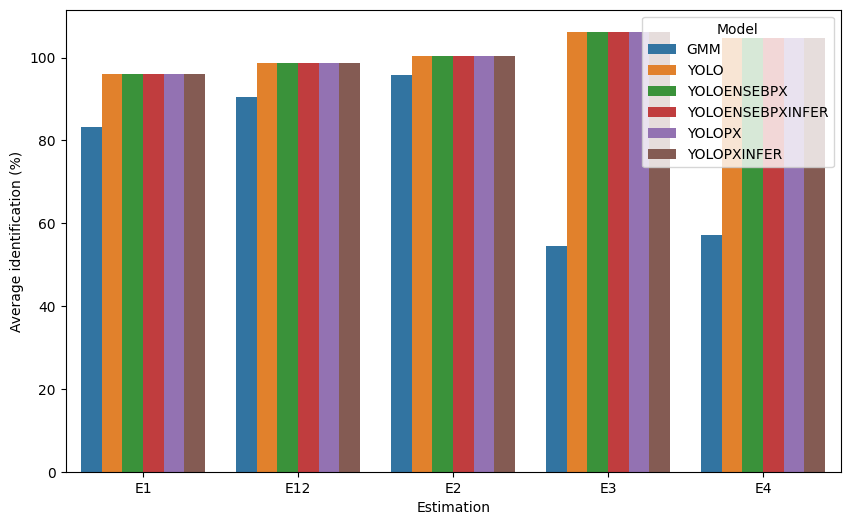

In [ ]:
# Compute average of Percentage for each model-estimation group
df_grouped = df_results.groupby(['model', 'estimation']).mean().reset_index()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data = df_grouped, x = 'estimation', y = 'Percentage', hue = 'model')
plt.ylabel('Average identification (%)')
plt.xlabel('Estimation')
plt.legend(title='Model')
plt.show()

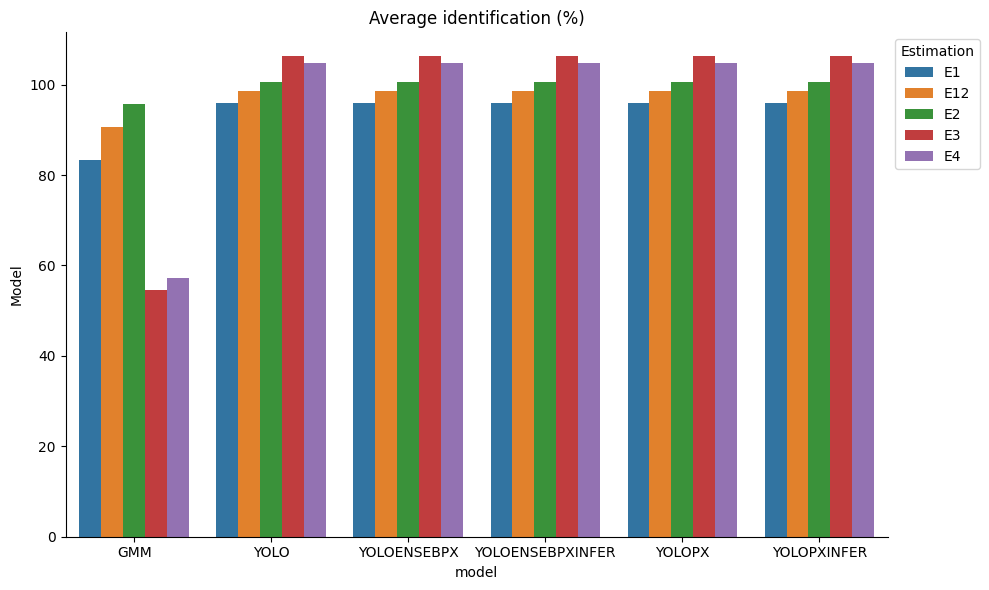

In [ ]:
# Compute average of Percentage for each model-estimation group
df_grouped = df_results.groupby(['model', 'estimation']).mean().reset_index()

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_grouped, x='model', y='Percentage', hue='estimation')
plt.title('Average identification (%)')
plt.ylabel('Model')

# Remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Move legend outside of the plotting area
plt.legend(title='Estimation', loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

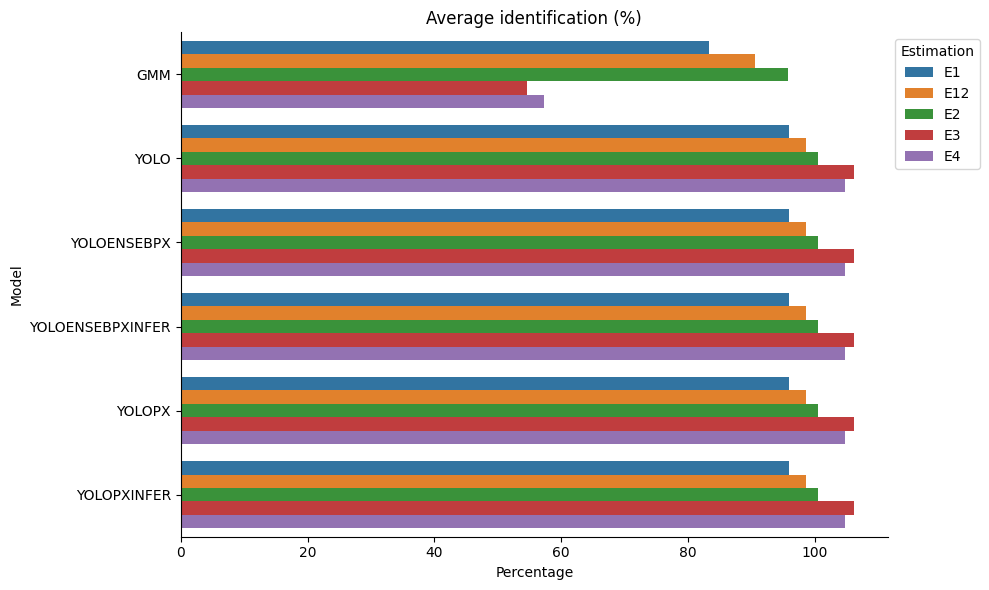

In [ ]:
# Compute average of Percentage for each model-estimation group
df_grouped = df_results.groupby(['model', 'estimation']).mean().reset_index()

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_grouped, y='model', x='Percentage', hue='estimation', orient='h')
plt.title('Average identification (%)')
plt.ylabel('Model')

# Remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Move legend outside of the plotting area
plt.legend(title='Estimation', loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

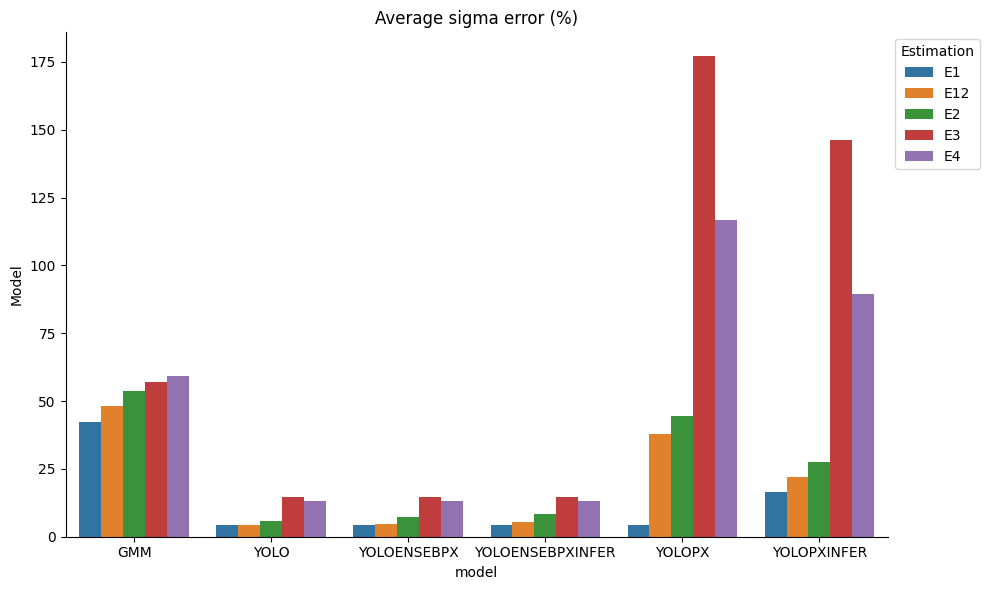

In [ ]:
# Compute average of Percentage for each model-estimation group
df_grouped = df_results.groupby(['model', 'estimation']).mean().reset_index()

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_grouped, x='model', y='RMSE_sigma', hue='estimation')
plt.title('Average sigma error (%)')
plt.ylabel('Model')

# Remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Move legend outside of the plotting area
plt.legend(title='Estimation', loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [ ]:
anal_var = 'RMSE_sigma'
print(df_results.groupby(['model', 'estimation']).mean().reset_index()[anal_var].min())
print(df_results.groupby(['model', 'estimation']).mean().reset_index()[anal_var].max())

4.166125101466319
177.0355657856955


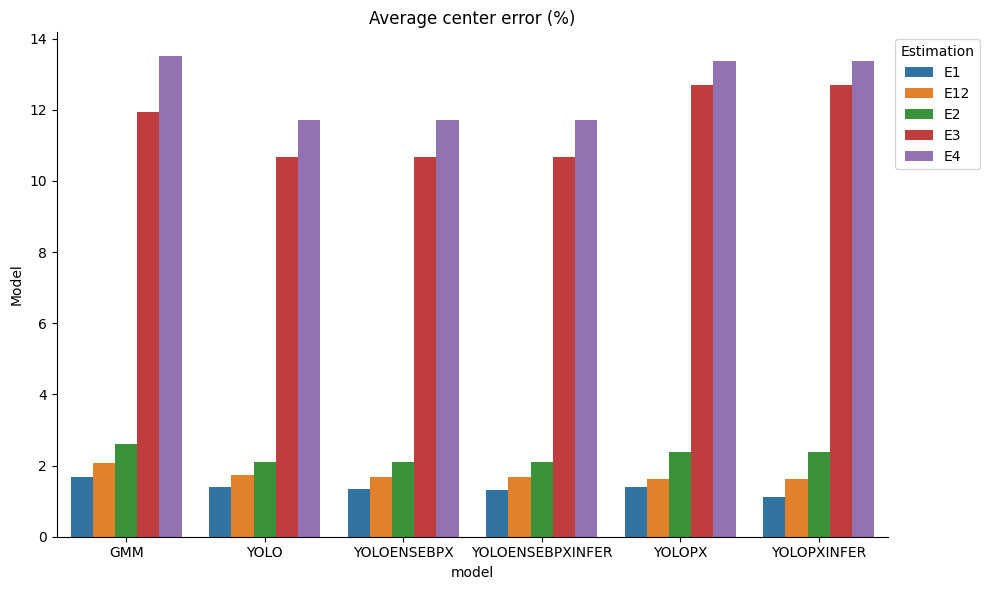

In [ ]:
# Compute average of Percentage for each model-estimation group
df_grouped = df_results.groupby(['model', 'estimation']).mean().reset_index()

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_grouped, x='model', y='RMSE_c', hue='estimation')
plt.title('Average center error (%)')
plt.ylabel('Model')

# Remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Move legend outside of the plotting area
plt.legend(title='Estimation', loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [ ]:
anal_var = 'RMSE_c'
print(df_results.groupby(['model', 'estimation']).mean().reset_index()[anal_var].min())
print(df_results.groupby(['model', 'estimation']).mean().reset_index()[anal_var].max())

1.1223282393818974
13.501006508453987


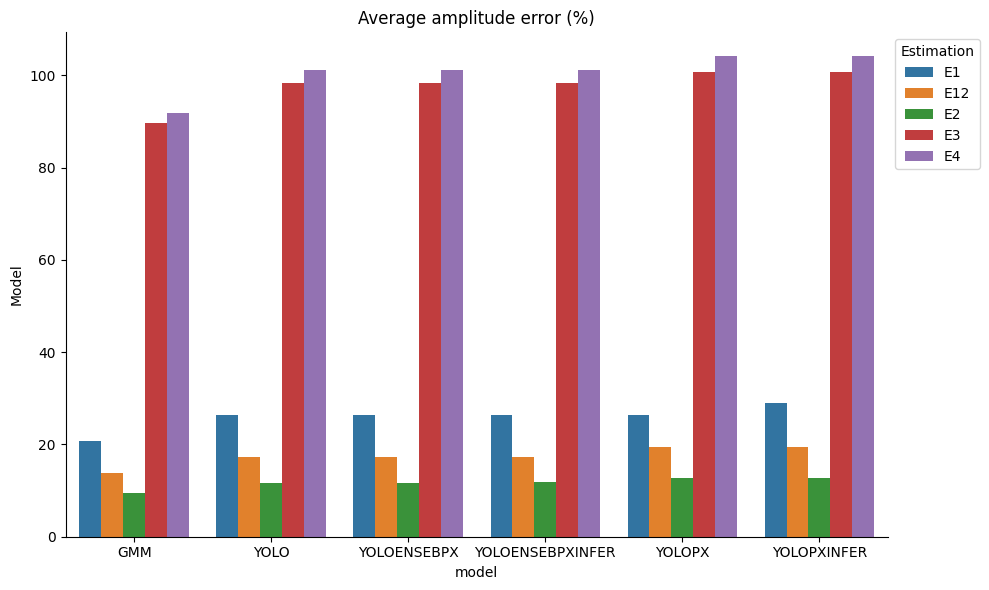

In [ ]:
# Compute average of Percentage for each model-estimation group
df_grouped = df_results.groupby(['model', 'estimation']).mean().reset_index()

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_grouped, x = 'model', y = 'RMSE_amplitude', hue='estimation')
plt.title('Average amplitude error (%)')
plt.ylabel('Model')

# Remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Move legend outside of the plotting area
plt.legend(title='Estimation', loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [ ]:
anal_var = 'RMSE_amplitude'
print(df_results.groupby(['model', 'estimation']).mean().reset_index()[anal_var].min())
print(df_results.groupby(['model', 'estimation']).mean().reset_index()[anal_var].max())

9.557512245176062
104.11018151130361


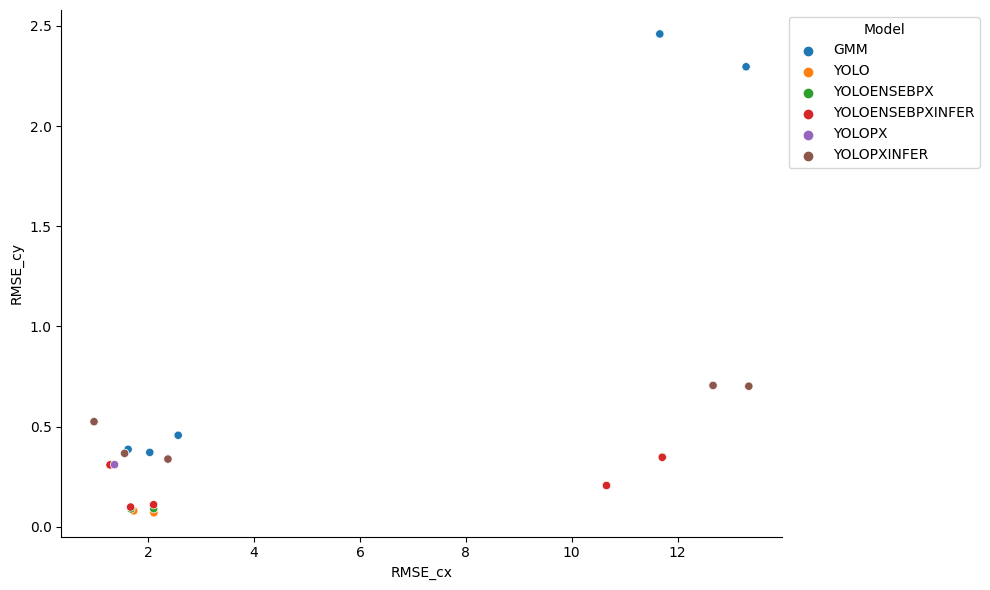

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10,6))
ax = sns.scatterplot(data = df_grouped, x='RMSE_cx', y='RMSE_cy', hue='model')

# Remove top and right spines for a cleaner look
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Move legend outside of the plotting area
plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [ ]:
df_results[df_results['estimation'] == 'E4'].sort_values('RMSE_sigma')

,Image,Number identified,Number identifiable,Percentage,RMSE_cx,RMSE_cy,RMSE_c,RMSE_sigmax,RMSE_sigmay,RMSE_sigma,RMSE_amplitude,MaxE_sigmax,MaxE_sigmay,MaxE_sigma,RMSEPixel,model,estimation
8,601,77,76,101.32,10.671888,0.282765,10.675633,10.408022,4.034298,11.162548,108.365280,41.764963,75.942608,86.669440,6.008307e+06,YOLO,E4
8,601,77,76,101.32,10.671888,0.282765,10.675633,10.408022,4.034298,11.162548,108.365280,41.764963,75.942608,86.669440,6.008307e+06,YOLOENSEBPX,E4
8,601,77,76,101.32,10.671888,0.282765,10.675633,10.408022,4.034298,11.162548,108.365280,41.764963,75.942608,86.669440,6.008307e+06,YOLOENSEBPXINFER,E4
16,614,78,77,101.30,11.363272,0.342513,11.368433,11.603176,3.637083,12.159855,105.260211,49.501033,75.207952,90.036595,5.855335e+06,YOLO,E4
16,614,78,77,101.30,11.363272,0.342513,11.368433,11.603176,3.637083,12.159855,105.260211,49.501033,75.207952,90.036595,5.855335e+06,YOLOENSEBPX,E4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,605,79,76,103.95,13.042502,0.683672,13.060408,72.974042,107.270706,129.739027,108.414453,1734.318831,931.142032,1968.473340,1.745476e+07,YOLOPX,E4
12,690,75,75,100.00,14.003762,0.706416,14.021569,46.967839,122.333549,131.039975,107.459950,282.340113,2915.639007,2929.277515,1.706396e+07,YOLOPX,E4
4,703,79,74,106.76,12.852405,0.587736,12.865837,43.642390,138.303106,145.025540,101.610935,372.521577,2511.802670,2539.276467,1.625973e+07,YOLOPX,E4
16,614,78,77,101.30,13.078921,0.613936,13.093322,58.018957,137.589679,149.322199,108.057351,1261.147451,2296.183254,2619.723350,2.087638e+07,YOLOPX,E4


In [ ]:
df_results[(df_results['estimation'] == 'E4')&(df_results['model'] == 'YOLO')].sort_values('RMSEPixel')

,Image,Number identified,Number identifiable,Percentage,RMSE_cx,RMSE_cy,RMSE_c,RMSE_sigmax,RMSE_sigmay,RMSE_sigma,RMSE_amplitude,MaxE_sigmax,MaxE_sigmay,MaxE_sigma,RMSEPixel,model,estimation
2,650,79,74,106.76,11.720052,0.271493,11.723196,13.606683,3.842444,14.138819,92.463773,54.645123,71.635075,90.098133,5.025654e+06,YOLO,E4
3,772,77,73,105.48,10.874915,0.270547,10.878280,12.160134,3.501767,12.654297,97.377974,59.901656,77.218050,97.728377,5.347911e+06,YOLO,E4
19,714,79,76,103.95,13.218036,1.278009,13.279676,11.364914,5.271129,12.527812,96.649068,48.429864,74.539059,88.890511,5.393485e+06,YOLO,E4
4,703,79,74,106.76,11.670233,0.333842,11.675007,12.580471,3.580131,13.079969,98.579538,53.182289,72.930960,90.262289,5.401819e+06,YOLO,E4
18,766,79,74,106.76,11.740463,0.271365,11.743599,13.320270,3.606505,13.799872,98.766425,62.564094,76.989278,99.204914,5.481781e+06,YOLO,E4
15,719,81,76,106.58,11.445589,0.327200,11.450265,12.536154,3.725107,13.077904,99.063194,55.371087,70.633578,89.749985,5.500501e+06,YOLO,E4
12,690,75,75,100.00,12.231569,0.296261,12.235156,11.687783,4.007571,12.355764,104.182215,46.334894,73.268287,86.690047,5.500651e+06,YOLO,E4
6,726,79,76,103.95,11.476783,0.280834,11.480219,12.278481,3.566778,12.786047,101.371324,55.590877,76.044190,94.196945,5.545687e+06,YOLO,E4
5,704,79,74,106.76,12.295365,0.340683,12.300084,13.386288,4.041603,13.983107,100.343894,59.574657,71.814967,93.308785,5.554036e+06,YOLO,E4
17,603,80,77,103.90,11.301782,0.266624,11.304927,12.630273,3.194121,13.027900,100.815735,58.059212,75.454700,95.206533,5.570945e+06,YOLO,E4


In [ ]:
df_results[df_results['estimation'] == 'E4'].sort_values('RMSEPixel')

,Image,Number identified,Number identifiable,Percentage,RMSE_cx,RMSE_cy,RMSE_c,RMSE_sigmax,RMSE_sigmay,RMSE_sigma,RMSE_amplitude,MaxE_sigmax,MaxE_sigmay,MaxE_sigma,RMSEPixel,model,estimation
9,622,39,76,51.32,9.472548,1.891286,9.659510,42.489668,39.716785,58.161799,91.774402,82.101198,65.703701,105.155043,1.139913e+06,GMM,E4
7,710,39,74,52.70,13.474298,2.159941,13.646320,40.957105,36.703361,54.996556,93.880792,86.601854,74.607212,114.307118,1.144388e+06,GMM,E4
17,603,46,77,59.74,16.717462,3.060827,16.995358,44.625690,41.316249,60.815168,92.187762,87.482702,141.296864,166.186723,1.162753e+06,GMM,E4
11,694,43,74,58.11,17.011773,2.376703,17.176995,40.105685,43.220446,58.961623,91.581569,85.828843,70.061190,110.793324,1.168627e+06,GMM,E4
19,714,43,76,56.58,14.483814,2.575709,14.711055,42.994923,42.958701,60.778396,86.436086,94.379491,174.952263,198.785771,1.171764e+06,GMM,E4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,719,81,76,106.58,13.007992,0.603446,13.021981,42.038471,102.295259,110.596352,101.934209,288.731621,1015.376159,1055.629998,1.736448e+07,YOLOPX,E4
14,605,79,76,103.95,13.042502,0.683672,13.060408,72.974042,107.270706,129.739027,108.414453,1734.318831,931.142032,1968.473340,1.745476e+07,YOLOPX,E4
1,777,81,77,105.19,12.853642,0.612011,12.868203,51.019416,99.041306,111.409879,103.205064,440.702003,1676.456347,1733.414013,1.750779e+07,YOLOPX,E4
16,614,78,77,101.30,13.078921,0.613936,13.093322,53.269453,106.173144,118.787083,108.057351,1261.147451,2296.183254,2619.723350,1.814443e+07,YOLOPXINFER,E4


In [ ]:
# Try using laplacian / derivatives - it may encode the information about the curves not begin "right" because of summing of another Gaussian
# Apriori: Information about local area, number of gaussians and its interferences
# Apriori: Information about gaussians not overlapped, centers and deviation

# Annotations

## SPIDER
- Radius of each hole in the grid is 14 mm (hemsworth1996 - Original NB design);
- Design assumed the beams as two Gaussian parts, core with the 85% power with divergence of 5 mrad and the halo (15% power) with poor divergence of > 15 mrad (hemsworth1996 - Original NB design);
- Expected core beamlet divergence of as low as 2 - 3 mrad (hemsworth1996 - reference 11)